In [65]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import scipy.optimize

# Extended vs. binned likelihood
- generate data as a sum of gaussian signal $\sim \mathcal N (\mu_s, \sigma_s)$ and flat background $\sim U(E_{n}^{min}, E_n^{max})$
	- $\mu_s = 2039~\mathrm{KeV}$
	- $\sigma_s = 15~\mathrm{KeV}$
	- $E_n^{min} = 2000~\mathrm{KeV}$
	- $E_n^{min} = 2080~\mathrm{KeV}$
- consider all combinations of numbers of signal and background events $s = \{ 5, 20, 50, 100 \}$ and $b = \{ 10, 30, 100, 200 \}$
- for each combination generate $10^4$ Toy MC data sets
- fit each Toy MC set with
	- extended likelihood method
	- binned likelihood with $1~\mathrm{KeV}$ binning
- benchmark both methods in terms of CPU time
- for each $s$ + $b$ + fit type combination plot $t_{extended} / t_{binned}$ vs $N_{events} / N_{bins}$

In [66]:
from dataclasses import dataclass
import time


E_MIN = 2000
E_MAX = 2080
E_PEAK = 2039
E_PEAK_SIGMA = 10


@dataclass
class FitResult:
    s_est: float
    b_est: float
    time: float


@dataclass
class FitResultsComparison:
    extended: FitResult
    extended_full: FitResult | None
    binned: FitResult


def compare_likelihood_methods(
    s_true: int,
    b_true: int,
    ax: plt.Axes | None,
    with_full_fit: bool = True,
) -> FitResultsComparison:
    signal_rv = scipy.stats.norm(loc=E_PEAK, scale=E_PEAK_SIGMA)
    background_rv = scipy.stats.uniform(loc=E_MIN, scale=E_MAX - E_MIN)

    signal_sample = signal_rv.rvs(size=s_true)
    background_sample = background_rv.rvs(size=b_true)

    sample = np.concatenate([signal_sample, background_sample], axis=0)
    np.random.shuffle(sample)
    s_b_bounds = scipy.optimize.Bounds([0, 0], [np.inf, np.inf])

    ########################################################
    # extended likelihood fit w/ known signal shape
    start = time.time()
    background_pdf_eval = background_rv.pdf(sample)
    signal_pdf_eval = signal_rv.pdf(sample)

    def negloglike_extended(theta: np.ndarray) -> float:
        s, b = theta
        return s + b - np.sum(np.log(s * signal_pdf_eval + b * background_pdf_eval))

    res = scipy.optimize.minimize(
        negloglike_extended,
        np.array([len(sample) / 2, len(sample) / 2]),
        bounds=s_b_bounds,
    )
    extended_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # extended likelihood fit w/ signal shape fit
    extended_full_fr: FitResult | None = None
    if with_full_fit:
        start = time.time()
        background_pdf_eval = background_rv.pdf(sample)

        def negloglike_extended_full(theta: np.ndarray) -> float:
            s, b, mu, sigma = theta
            return (
                s
                + b
                - np.sum(
                    np.log(
                        s * scipy.stats.norm.pdf(sample, loc=mu, scale=sigma)
                        + b * background_pdf_eval
                    )
                )
            )

        res = scipy.optimize.minimize(
            negloglike_extended_full,
            np.array([len(sample) / 2, len(sample) / 2, sample.mean(), sample.std()]),
            bounds=scipy.optimize.Bounds(
                [0, 0, E_MIN, 0], [np.inf, np.inf, E_MAX, np.inf]
            ),
        )
        extended_full_fr = FitResult(
            s_est=res.x[0], b_est=res.x[1], time=time.time() - start
        )
        extended_full_mu_est = res.x[2]
        extended_full_sigma_est = res.x[3]

    ########################################################
    # binned likelihood fit
    start = time.time()
    binning_step = 1  # KeV
    bin_edges = np.linspace(E_MIN, E_MAX, num=1 + (E_MAX - E_MIN) // binning_step)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    signal_pdf_eval_bc = signal_rv.pdf(bin_centers)
    background_pdf_eval_bc = background_rv.pdf(bin_centers)
    binned_sample, _ = np.histogram(
        sample,
        bins=bin_edges,
    )

    def negloglike_binned(theta: np.ndarray) -> float:
        s, b = theta
        return s + b -np.sum(
            binned_sample
            * np.log(binning_step * (s * signal_pdf_eval_bc + b * background_pdf_eval_bc) / (s + b))
        )

    res = scipy.optimize.minimize(
        negloglike_binned,
        np.array([len(sample) / 2, len(sample) / 2]),
        bounds=s_b_bounds,
    )
    binned_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # plotting
    if ax is not None:
        E_range = np.linspace(E_MIN, E_MAX, num=500)
        E_bins = np.linspace(E_MIN, E_MAX, num=min(50, (s_true + b_true) // 3))
        ax.hist(
            [
                background_sample,
                signal_sample,
            ],
            bins=E_bins,
            stacked=True,
            density=True,
            # label=["Background", "Signal"],
        )

        def plot_mixture_pdf(
            s: float,
            b: float,
            color: str,
            label: str,
            signal_rv_override: scipy.stats.rv_continuous | None = None,
            is_dashed: bool = False,
        ):
            ax.plot(
                E_range,
                (
                    b * background_rv.pdf(E_range)
                    + s * (signal_rv_override or signal_rv).pdf(E_range)
                )
                / (s + b),
                color=color,
                label=label,
                linestyle="--" if is_dashed else None,
            )

        plot_mixture_pdf(s_true, b_true, "k", "True PDF")
        plot_mixture_pdf(
            extended_fr.s_est,
            extended_fr.b_est,
            "r",
            "Extended $ \\mathcal{L} $",
            # is_dashed=True,
        )
        if with_full_fit:
            plot_mixture_pdf(
                extended_full_fr.s_est,
                extended_full_fr.b_est,
                "b",
                "Extended $ \\mathcal{L} $ w/ pulse",
                signal_rv_override=scipy.stats.norm(
                    loc=extended_full_mu_est,
                    scale=extended_full_sigma_est,
                ),
            )
        plot_mixture_pdf(
            binned_fr.s_est,
            binned_fr.b_est,
            "g",
            "Binned $ \\mathcal{L} $",
            # is_dashed=True,
        )

        ax.set_yticks([])
        ax.set_xlim(E_MIN, E_MAX)
        ax.legend()

    return FitResultsComparison(
        extended=extended_fr,
        extended_full=extended_full_fr,
        binned=binned_fr,
    )

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_68395/834283915.py:108: RuntimeWarning: invalid value encountered in divide
  * np.log(binning_step * (s * signal_pdf_eval_bc + b * background_pdf_eval_bc) / (s + b))
/Users/njvh/Documents/Science/GSSI/STAT/venv/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)


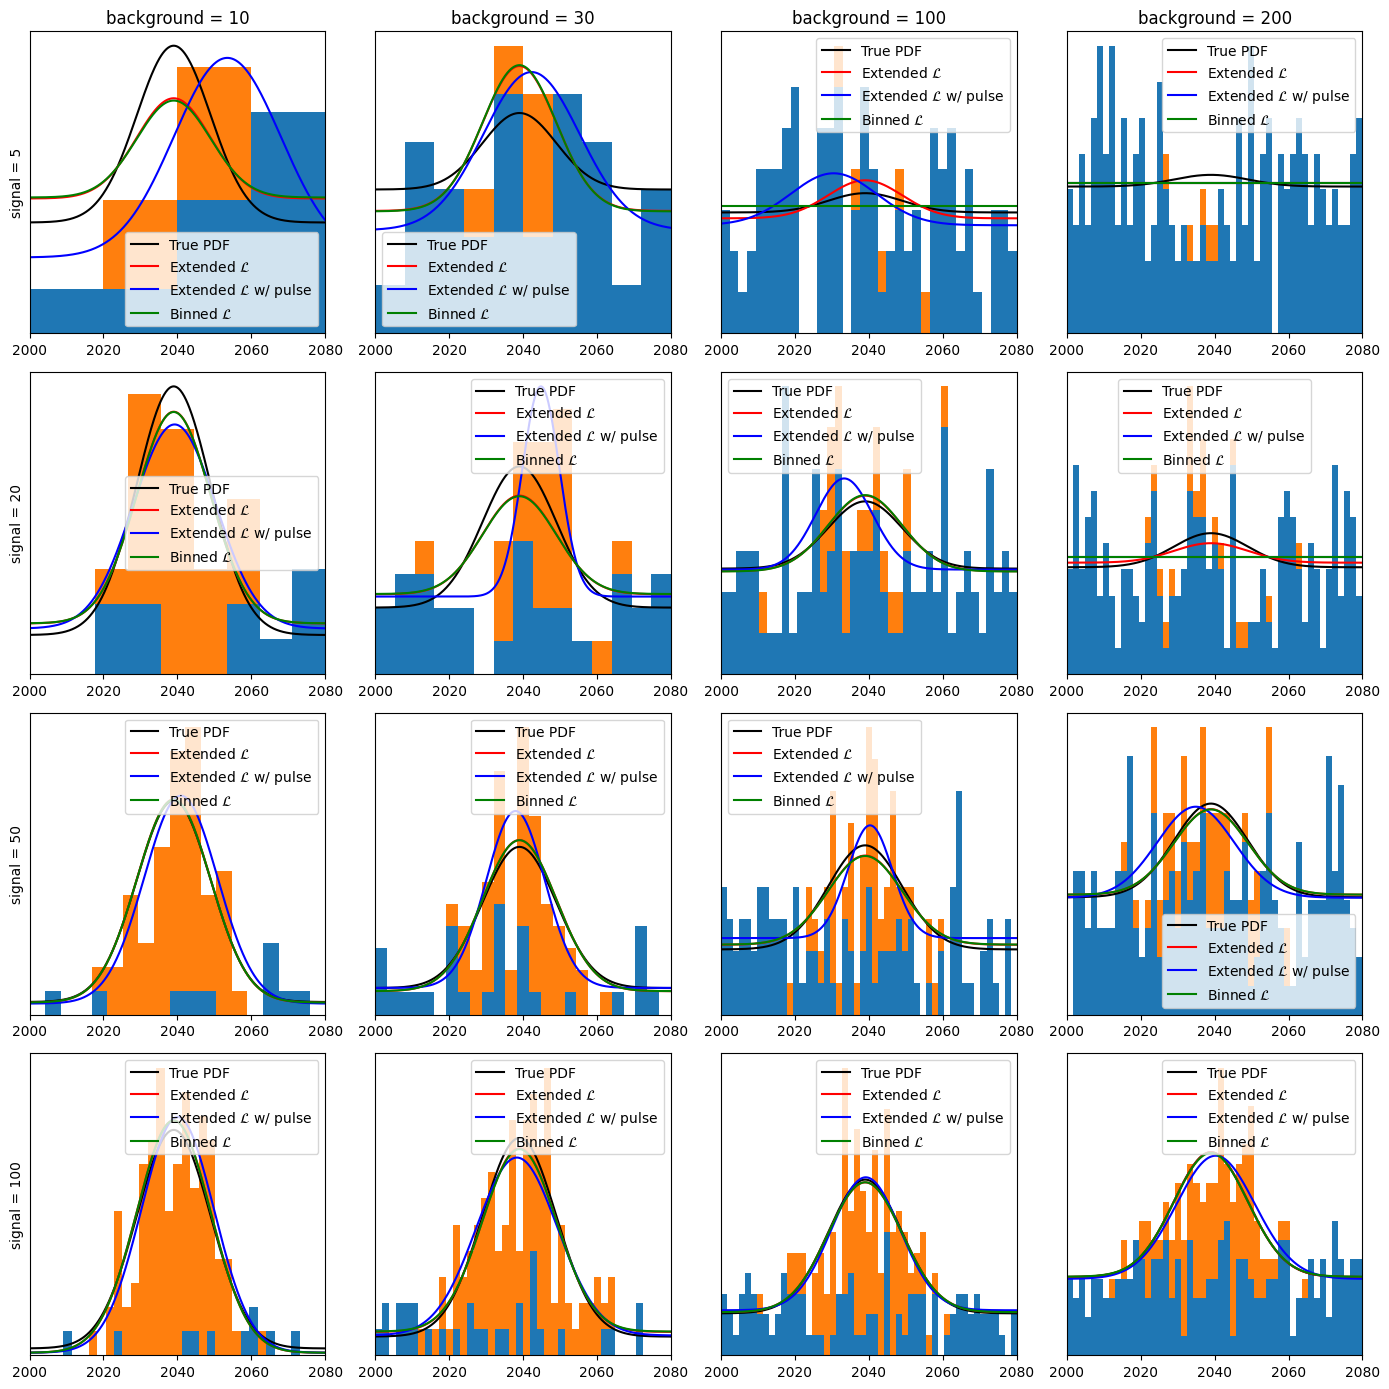

In [67]:
s_options = [5, 20, 50, 100]
b_options = [10, 30, 100, 200]
fig, axes = plt.subplots(
    nrows=len(s_options),
    ncols=len(b_options),
    figsize=(3.5 * len(b_options), 3.5 * len(s_options)),
)

for s, ax_row in zip(s_options, axes):
    ax_row[0].set_ylabel(f"signal = {s}")
    for b, ax in zip(b_options, ax_row):
        compare_likelihood_methods(s, b, ax)
        if s == s_options[0]:
            ax.set_title(f"background = {b}")

plt.tight_layout()
plt.show()

  0%|          | 0/320 [00:00<?, ?it/s]/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_68395/834283915.py:108: RuntimeWarning: invalid value encountered in divide
  * np.log(binning_step * (s * signal_pdf_eval_bc + b * background_pdf_eval_bc) / (s + b))
100%|██████████| 320/320 [00:46<00:00,  6.88it/s]


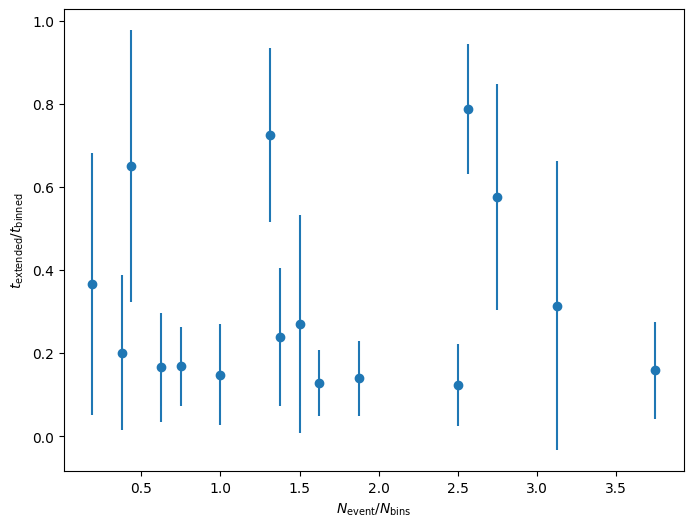

In [68]:
from tqdm import tqdm
s_options = [5, 20, 50, 100]
b_options = [10, 30, 100, 200]
comparisons_count = 20

t_fraction_mean = []
t_fraction_std = []
n_fraction = []
with tqdm(total=len(s_options) * len(b_options) * comparisons_count) as progress_bar:
    for s in s_options:
        for b in b_options:
            n_fraction.append((s + b) / 80)
            t_frac_sample = []
            for _ in range(comparisons_count):
                res = compare_likelihood_methods(s, b, ax, with_full_fit=False)
                progress_bar.update()
                t_frac_sample.append(res.extended.time / res.binned.time)
            t_fraction_mean.append(np.mean(t_frac_sample))
            t_fraction_std.append(np.std(t_frac_sample))

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(n_fraction, t_fraction_mean, t_fraction_std, linestyle="", marker="o")
ax.set_xlabel("$ N_{\mathrm{event}} / N_{\mathrm{bins}} $")
ax.set_ylabel("$ t_{\mathrm{extended}} / t_{\mathrm{binned}} $")
plt.show()

# $\chi^2$ fit
- generate $n=11$ points with the following coordinates:
	- $x_i = 0, 100, 200, …, 1000$
	- $y_i = m x_i + q + \delta y_i$ with $m=1.5$, $q=3$
	- $\delta y_i \sim \mathcal N(0, \sigma_i)$ with $\sigma_i$ randomly selected from $[10, 100]$
- fit the points with $\chi^2$ method and retrieve $\chi^2$ value from the fit
- repeat the process $10^4$ times and histogram $\chi^2$ value
- overlap the theoretical distribution for $\chi^2$ statistic

In [69]:
def linear_lsq(
    ax: plt.Axes | None = None,
    n_pts: int = 11,
    random_error_overestimation_factor: float = 1.0,
    quadratic_coefficient: float = 0.0,
) -> float:
    a_true = 1.5
    b_true = 3

    x = np.linspace(0, 1000, n_pts)
    y_sigma = np.random.uniform(10, 100, size=n_pts)
    y = (
        a_true * x
        + b_true
        + np.random.normal(loc=0, scale=y_sigma)
        + quadratic_coefficient * x**2
    )

    y_sigma = random_error_overestimation_factor * y_sigma

    sigma_sq = 1 / np.sum(1 / y_sigma**2)
    weights = sigma_sq / y_sigma**2

    x_mean = np.sum(weights * x)
    y_mean = np.sum(weights * y)
    a_est = np.sum(weights * (x - x_mean) * (y - y_mean)) / np.sum(
        weights * (x - x_mean) ** 2
    )
    b_est = y_mean - a_est * x_mean

    chi2 = np.sum(((y - a_est * x - b_est) / y_sigma) ** 2)
    ndf = n_pts - 2

    if ax is not None:
        ax.errorbar(x, y, y_sigma, linestyle="none", marker="o")
        ax.plot(x, quadratic_coefficient * x ** 2 + a_true * x + b_true, "k", label="True")
        ax.plot(
            x,
            a_est * x + b_est,
            "r",
            label=f"LSQ fit ($ \chi^2 / \mathrm{{d.o.f.}} = {chi2 / ndf:.3f} $)",
        )
        ax.legend()

    return chi2

61.09922224437075

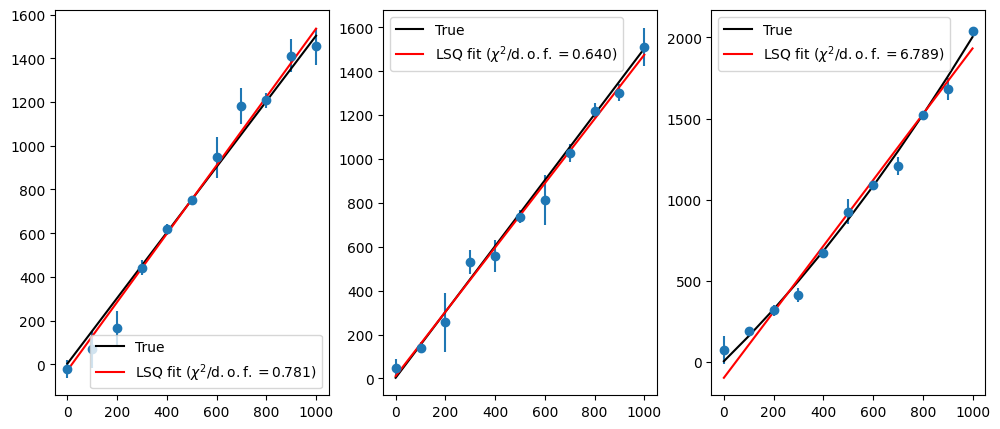

In [70]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
linear_lsq(axes[0])
linear_lsq(axes[1], random_error_overestimation_factor=1.4)
linear_lsq(axes[2], quadratic_coefficient=5e-4)

100%|██████████| 10000/10000 [00:00<00:00, 30150.73it/s]


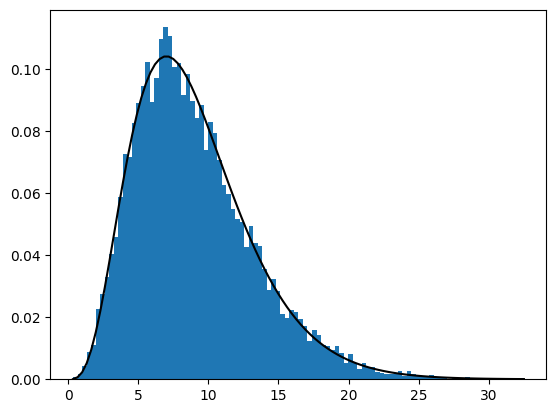

In [71]:
from tqdm import trange

n_pts = 11

chi2_sample = np.array([linear_lsq(n_pts=n_pts) for _ in trange(10_000)])

fig, ax = plt.subplots()

ax.hist(chi2_sample, bins=100, density=True)
limit_chi2_rv = scipy.stats.chi2(df=n_pts - 2)
chi2_range = np.linspace(chi2_sample.min(), chi2_sample.max(), 100)
ax.plot(chi2_range, limit_chi2_rv.pdf(chi2_range), color="k")

plt.show()

# $\chi^2$ fit with overestimated random errors
- same as before, but:
    - enlarge $\sigma_i$ fed into the fit by factor $k = \{1, 1.1, 1.2, 1.3, 1.4\}$
    - histogram $\chi^2$ for each $k$ and compare

100%|██████████| 10000/10000 [00:00<00:00, 31342.95it/s]


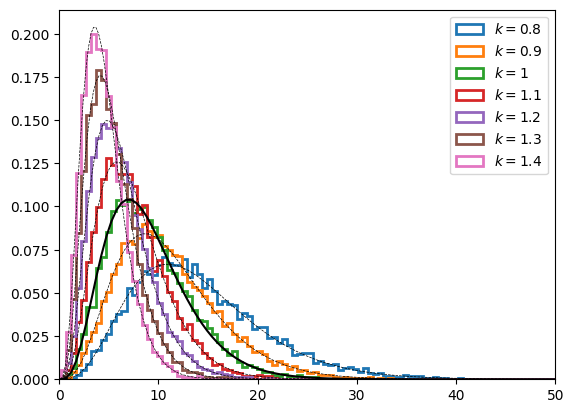

In [72]:
from tqdm import trange

fig, ax = plt.subplots()
n_pts = 11
c_options = [0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4]

chi2_min = np.inf
chi2_max = 0
chi2_samples: list[tuple[np.ndarray, str]] = []
for c in c_options:
    chi2_sample = np.array(
        [
            linear_lsq(
                n_pts=n_pts,
                random_error_overestimation_factor=c,
            )
            for _ in trange(10_000)
        ]
    )
    chi2_min = min(chi2_min, chi2_sample.min())
    chi2_max = max(chi2_max, chi2_sample.max())
    chi2_samples.append([chi2_sample, f"$ k = {c} $"])

bins = np.linspace(chi2_min, chi2_max, 100)
for sample, label in chi2_samples:
    ax.hist(sample, bins=bins, label=label, histtype="step", linewidth=2, density=True)

limit_chi2_rv = scipy.stats.chi2(df=n_pts - 2)
chi2_range = np.linspace(chi2_min, chi2_max, 100)
ax.plot(chi2_range, limit_chi2_rv.pdf(chi2_range), color="k")

for c in c_options:
    if c == 1:
        continue
    ax.plot(chi2_range / c**2, c**2 * limit_chi2_rv.pdf(chi2_range), color="k", linewidth=0.5, linestyle="--")

ax.legend()
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlim(0, 50)

plt.show()

# $\chi^2$ fit with unaccounted systematic error
- use second-order polynomial to generate data
	- $q + m x_i + c x_i^2$
- use values $c = \{ 0, 10^{-4}, 2 \cdot 10^{-4}, ..., 5 \cdot 10^{-4} \}$
- fit with the same function
- histogram $\chi^2$ for each $c$ and compare

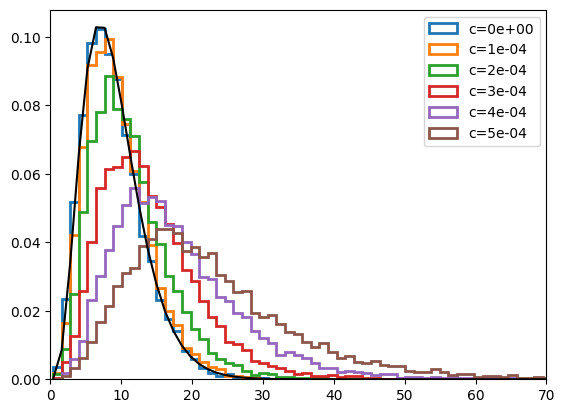

In [73]:
fig, ax = plt.subplots()
n_pts = 11
c_options = np.arange(6) * 1e-4

chi2_min = np.inf
chi2_max = 0
chi2_samples: list[tuple[np.ndarray, str]] = []
for c in c_options:
    chi2_sample = np.array(
        [linear_lsq(n_pts=n_pts, quadratic_coefficient=c) for _ in range(10_000)]
    )
    chi2_min = min(chi2_min, chi2_sample.min())
    chi2_max = max(chi2_max, chi2_sample.max())
    chi2_samples.append([chi2_sample, f"c={c:.0e}"])

bins = np.linspace(chi2_min, chi2_max, 100)
for sample, label in chi2_samples:
    ax.hist(sample, bins=bins, label=label, histtype="step", linewidth=2, density=True)

limit_chi2_rv = scipy.stats.chi2(df=n_pts - 2)
chi2_range = np.linspace(chi2_min, chi2_max, 100)
ax.plot(chi2_range, limit_chi2_rv.pdf(chi2_range), color="k")
ax.legend()
ax.set_xlim(0, 70)

plt.show()

# $\mathcal L$ vs $\chi^2$ fits for binned Poisson data
- generate signal + background data same as imn 1st ex.
- use $s = \{ 10, 100, 1000, 10000 \}$ and the same range for $b$
- generate $300$ toy MC sets for each combination and bin them with $0.1~\mathrm{KeV}$ binning
- fit each one with $\mathcal L$, $\chi^2_N$, $\chi^2_p$
- plot the following:
	- $\forall$ combinations plot the distribution of the best-fit of $s$, overlapping the distributions from the 3 methods
	- same for best-fit estimation for $b$
	- plot 2-dim distros for best-fit $s$ and $b$ for each method

In [94]:
from dataclasses import dataclass
from typing import Literal


E_MIN = 2000
E_MAX = 2080
E_PEAK = 2039
E_PEAK_SIGMA = 10


@dataclass
class BinnedFitResultsComparison:
    binned_like: FitResult
    unbinned_like: FitResult
    chi2_neyman: FitResult
    chi2_pearson: FitResult
    # curve: FitResult


def compare_binned_likelihood_methods(
    s_true: int,
    b_true: int,
    ax: plt.Axes | None = None,
) -> BinnedFitResultsComparison:
    signal_rv = scipy.stats.norm(loc=E_PEAK, scale=E_PEAK_SIGMA)
    background_rv = scipy.stats.uniform(loc=E_MIN, scale=E_MAX - E_MIN)

    signal_sample = signal_rv.rvs(size=s_true)
    background_sample = background_rv.rvs(size=b_true)

    sample: np.ndarray = np.concatenate([signal_sample, background_sample], axis=0)
    np.random.shuffle(sample)

    binning_step = 1  # KeV
    bin_edges = np.linspace(E_MIN, E_MAX, num=1 + int((E_MAX - E_MIN) / binning_step))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
    signal_pdf_in_bins = signal_rv.pdf(bin_centers)
    background_pdf_in_bins = background_rv.pdf(bin_centers)
    binned_sample, _ = np.histogram(sample, bins=bin_edges)

    n = len(sample)
    b_initial_est = max(0, min(n, np.median(np.histogram(sample, bins=30)[0]) * 30))
    # print(b_initial_est)
    minimize_kwargs = dict(
        bounds=scipy.optimize.Bounds([0, 0], [1.5 * len(sample), 1.5 * len(sample)]),
        x0=np.array([n - b_initial_est, b_initial_est]),
        # x0=np.array([s_true, b_true]),
        options={"maxiter": 1_000_000},
        method="Nelder-Mead",
    )

    ########################################################
    # binned likelihood fit
    start = time.time()

    def negloglike_binned(theta: np.ndarray) -> float:
        s, b = theta
        return (s + b) - np.sum(
            binned_sample
            * np.log(
                binning_step * (s * signal_pdf_in_bins + b * background_pdf_in_bins)
            )
        )

    res = scipy.optimize.minimize(negloglike_binned, **minimize_kwargs)
    binned_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # neyman chi2 fit
    start = time.time()

    def chi2_func(kind: Literal["neyman", "pearson"]):
        def chi2(theta: np.ndarray) -> float:
            s, b = theta
            lambda_i = binning_step * (
                s * signal_pdf_in_bins + b * background_pdf_in_bins
            )
            if kind == "neyman":
                mask = binned_sample > 0
                lambda_i = lambda_i[mask]
                k_i = binned_sample[mask] * len(mask) / sum(mask)
                sigma2_i = binned_sample[mask]
            else:
                k_i = binned_sample
                sigma2_i = lambda_i
            return np.sum(((k_i - lambda_i) ** 2) / sigma2_i)

        return chi2

    res = scipy.optimize.minimize(chi2_func("neyman"), **minimize_kwargs)
    chi2_neyman_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # Pearson chi2 fit
    start = time.time()
    res = scipy.optimize.minimize(chi2_func("pearson"), **minimize_kwargs)
    chi2_pearson_fr = FitResult(
        s_est=res.x[0], b_est=res.x[1], time=time.time() - start
    )

    ########################################################
    # scipy built-in fit

    # def hist_curve(E: np.ndarray, s: float, b: float) -> float:
    #     return binning_step * (
    #         s * signal_rv.pdf(E) + b * background_rv.pdf(E) / (s + b)
    #     )

    # start = time.time()
    # popt, *_ = scipy.optimize.curve_fit(
    #     hist_curve,
    #     bin_centers,
    #     binned_sample,
    #     p0=minimize_kwargs["x0"],
    #     sigma=np.sqrt(binned_sample),
    # )
    # curve_fit_fr = FitResult(
    #     s_est=popt[0],
    #     b_est=popt[1],
    #     time=time.time() - start,
    # )

    ########################################################
    # extended likelihood fit

    start = time.time()
    background_pdf_eval = background_rv.pdf(sample)
    signal_pdf_eval = signal_rv.pdf(sample)

    def negloglike_extended(theta: np.ndarray) -> float:
        s, b = theta
        return s + b - np.sum(np.log(s * signal_pdf_eval + b * background_pdf_eval))

    res = scipy.optimize.minimize(negloglike_extended, **minimize_kwargs)
    unbinned_fr = FitResult(s_est=res.x[0], b_est=res.x[1], time=time.time() - start)

    ########################################################
    # plotting
    if ax is not None:
        E_range = np.linspace(E_MIN, E_MAX, num=500)
        # E_bins = np.linspace(E_MIN, E_MAX, num=min(50, (s_true + b_true) // 3))
        E_bins = np.linspace(E_MIN, E_MAX, num=int((E_MAX - E_MIN) / binning_step))
        ax.hist(
            [
                background_sample,
                signal_sample,
            ],
            bins=E_bins,
            stacked=True,
            # density=True,
            # label=["Background", "Signal"],
        )

        def plot_mixture_pdf(
            s: float,
            b: float,
            color: str,
            label: str,
            signal_rv_override: scipy.stats.rv_continuous | None = None,
            **plot_kw,
        ):
            ax.plot(
                E_range,
                (
                    (E_bins[1] - E_bins[0])
                    * (
                        b * background_rv.pdf(E_range)
                        + s * (signal_rv_override or signal_rv).pdf(E_range)
                    )
                ),
                color=color,
                label=label,
                **plot_kw,
            )

        plot_mixture_pdf(s_true, b_true, "k", "True PDF", linewidth=2)
        plot_mixture_pdf(
            minimize_kwargs["x0"][0],
            minimize_kwargs["x0"][1],
            "k",
            "Initial approx.",
            linewidth=1.5,
            linestyle="--",
        )
        plot_mixture_pdf(
            binned_fr.s_est, binned_fr.b_est, "g", "Binned $ \\mathcal{L} $"
        )
        plot_mixture_pdf(
            chi2_neyman_fr.s_est, chi2_neyman_fr.b_est, "r", "$ \\chi^2_{N} $ fit"
        )
        plot_mixture_pdf(
            chi2_pearson_fr.s_est, chi2_pearson_fr.b_est, "b", "$ \\chi^2_{P} $ fit"
        )
        plot_mixture_pdf(
            unbinned_fr.s_est, unbinned_fr.b_est, "m", "Unbinned $ \\mathcal{L} $ fit"
        )
        # plot_mixture_pdf(
        #     curve_fit_fr.s_est, curve_fit_fr.b_est, "m", "Scipy curve fit"
        # )

        ax.set_xlim(E_MIN, E_MAX)
        # ax.set_yticks([])
        ax.legend()

    return BinnedFitResultsComparison(
        binned_like=binned_fr,
        unbinned_like=unbinned_fr,
        chi2_neyman=chi2_neyman_fr,
        chi2_pearson=chi2_pearson_fr,
        # curve=curve_fit_fr,
    )

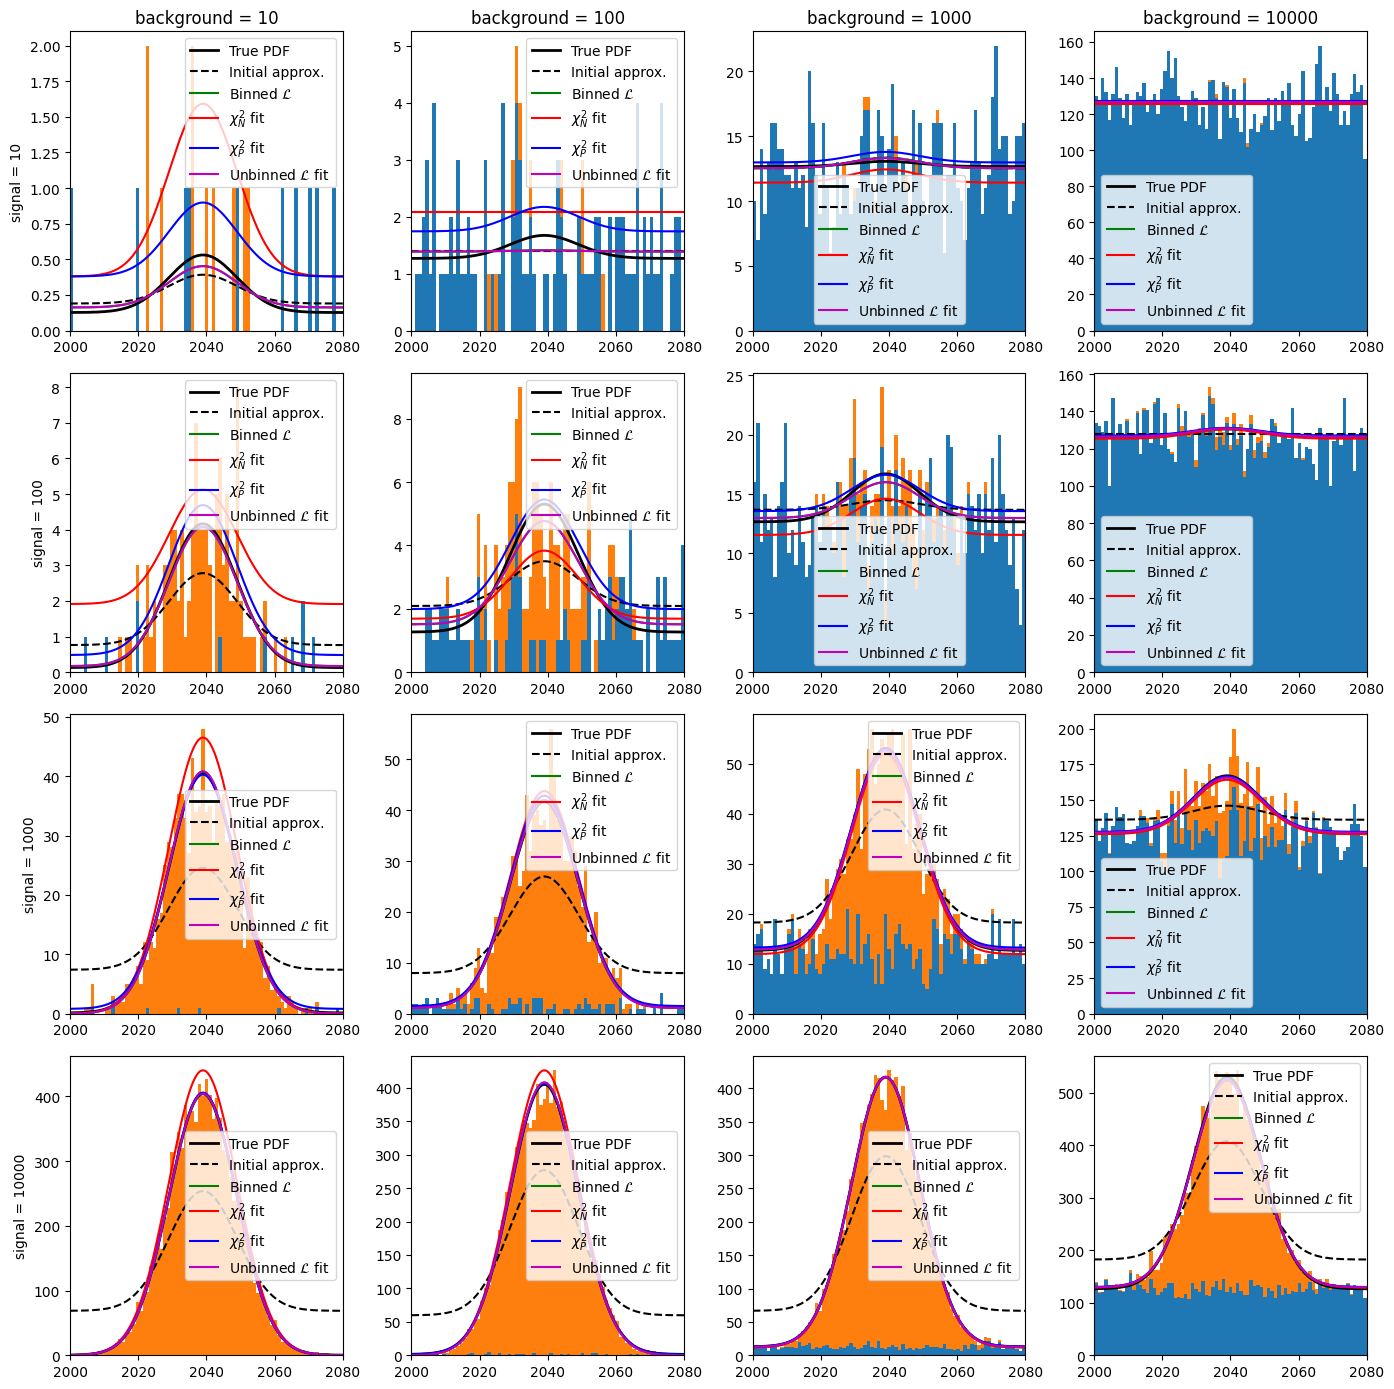

In [96]:
s_options = [10, 100, 1000, 10000]
b_options = [10, 100, 1000, 10000]
fig, axes = plt.subplots(
    nrows=len(s_options),
    ncols=len(b_options),
    figsize=(3.5 * len(b_options), 3.5 * len(s_options)),
)

for s, ax_row in zip(s_options, axes):
    ax_row[0].set_ylabel(f"signal = {s}")
    for b, ax in zip(b_options, ax_row):
        compare_binned_likelihood_methods(s, b, ax)
        if s == s_options[0]:
            ax.set_title(f"background = {b}")

plt.tight_layout()
plt.show()

In [97]:
import itertools


def plot_comparison(param: Literal["s", "b", "n"]) -> None:
    def get_param(c: FitResult) -> float:
        if param == "b":
            return c.b_est
        elif param == "s":
            return c.s_est
        else:
            return c.s_est + c.b_est

    s_options = [10, 100, 1000, 10000]
    b_options = s_options.copy()
    comparisons_count = 300

    fig, axes = plt.subplots(
        nrows=len(s_options),
        ncols=len(b_options),
        figsize=(3.5 * len(b_options), 3.5 * len(s_options)),
    )

    for s, ax_row in zip(s_options, axes):
        ax_row[0].set_ylabel(f"signal = {s}")
        for b, ax in zip(b_options, ax_row):
            comparisons: list[BinnedFitResultsComparison] = [
                compare_binned_likelihood_methods(s, b)
                for _ in range(comparisons_count)
            ]
            all_estimations = np.array(
                list(
                    itertools.chain.from_iterable(
                        [
                            get_param(c.binned_like),
                            get_param(c.chi2_neyman),
                            get_param(c.chi2_pearson),
                            get_param(c.unbinned_like),
                        ]
                        for c in comparisons
                    )
                )
            )
            bins = np.linspace(all_estimations.min(), all_estimations.max(), 30)
            ax.hist(
                [get_param(c.binned_like) for c in comparisons],
                alpha=0.3,
                bins=bins,
                label="Binned $ \mathcal{L} $",
            )
            ax.hist(
                [get_param(c.unbinned_like) for c in comparisons],
                alpha=0.3,
                bins=bins,
                label="Unbinned $ \mathcal{L} $",
            )
            ax.hist(
                [get_param(c.chi2_neyman) for c in comparisons],
                alpha=0.3,
                bins=bins,
                label="$ \\chi^2_{N} $ fit",
            )
            ax.hist(
                [get_param(c.chi2_pearson) for c in comparisons],
                alpha=0.3,
                bins=bins,
                label="$ \\chi^2_{P} $ fit",
            )
            ax.legend()
            ax.axvline(
                s if param == "s" else b if param == "b" else s + b,
                color="black",
            )
            if s == s_options[0]:
                ax.set_title(f"background = {b}")

    fig.suptitle(f"{param} estimation")
    plt.tight_layout()
    plt.show()

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_68395/4150171878.py:132: RuntimeWarning: divide by zero encountered in log
  return s + b - np.sum(np.log(s * signal_pdf_eval + b * background_pdf_eval))


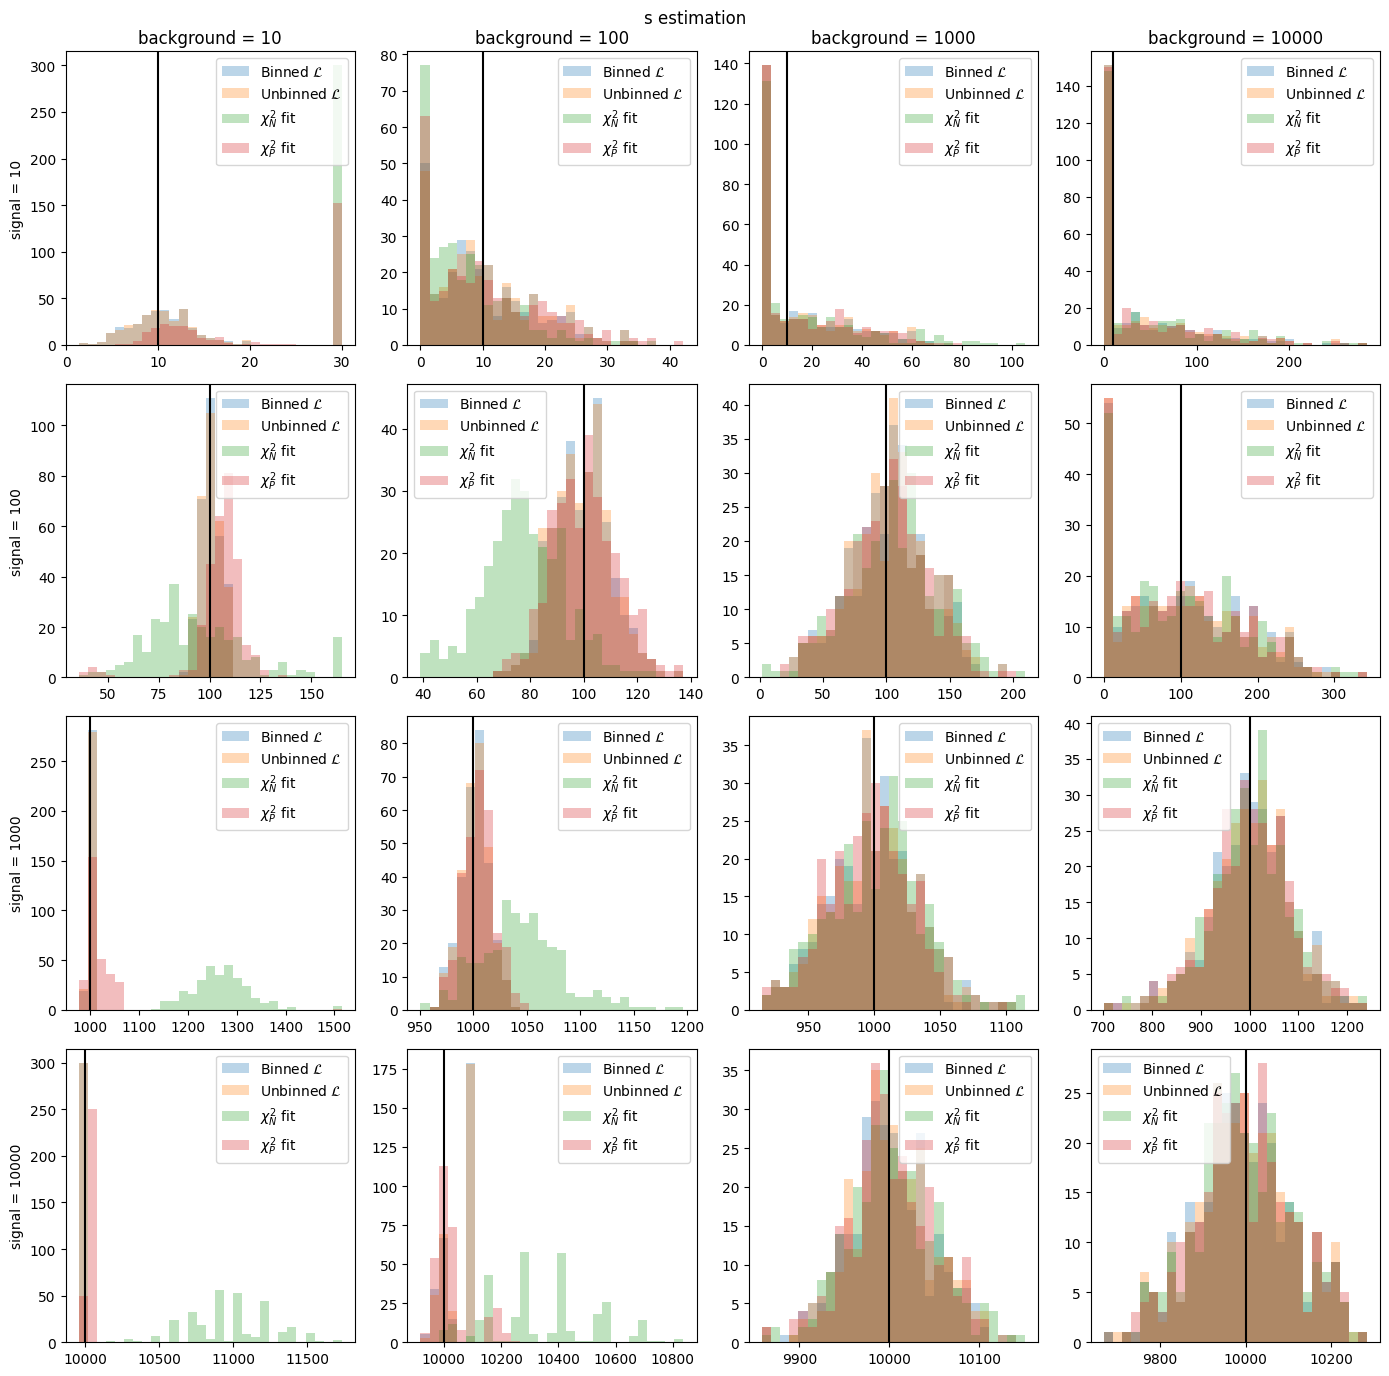

In [98]:
plot_comparison("s")

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_68395/4150171878.py:132: RuntimeWarning: divide by zero encountered in log
  return s + b - np.sum(np.log(s * signal_pdf_eval + b * background_pdf_eval))


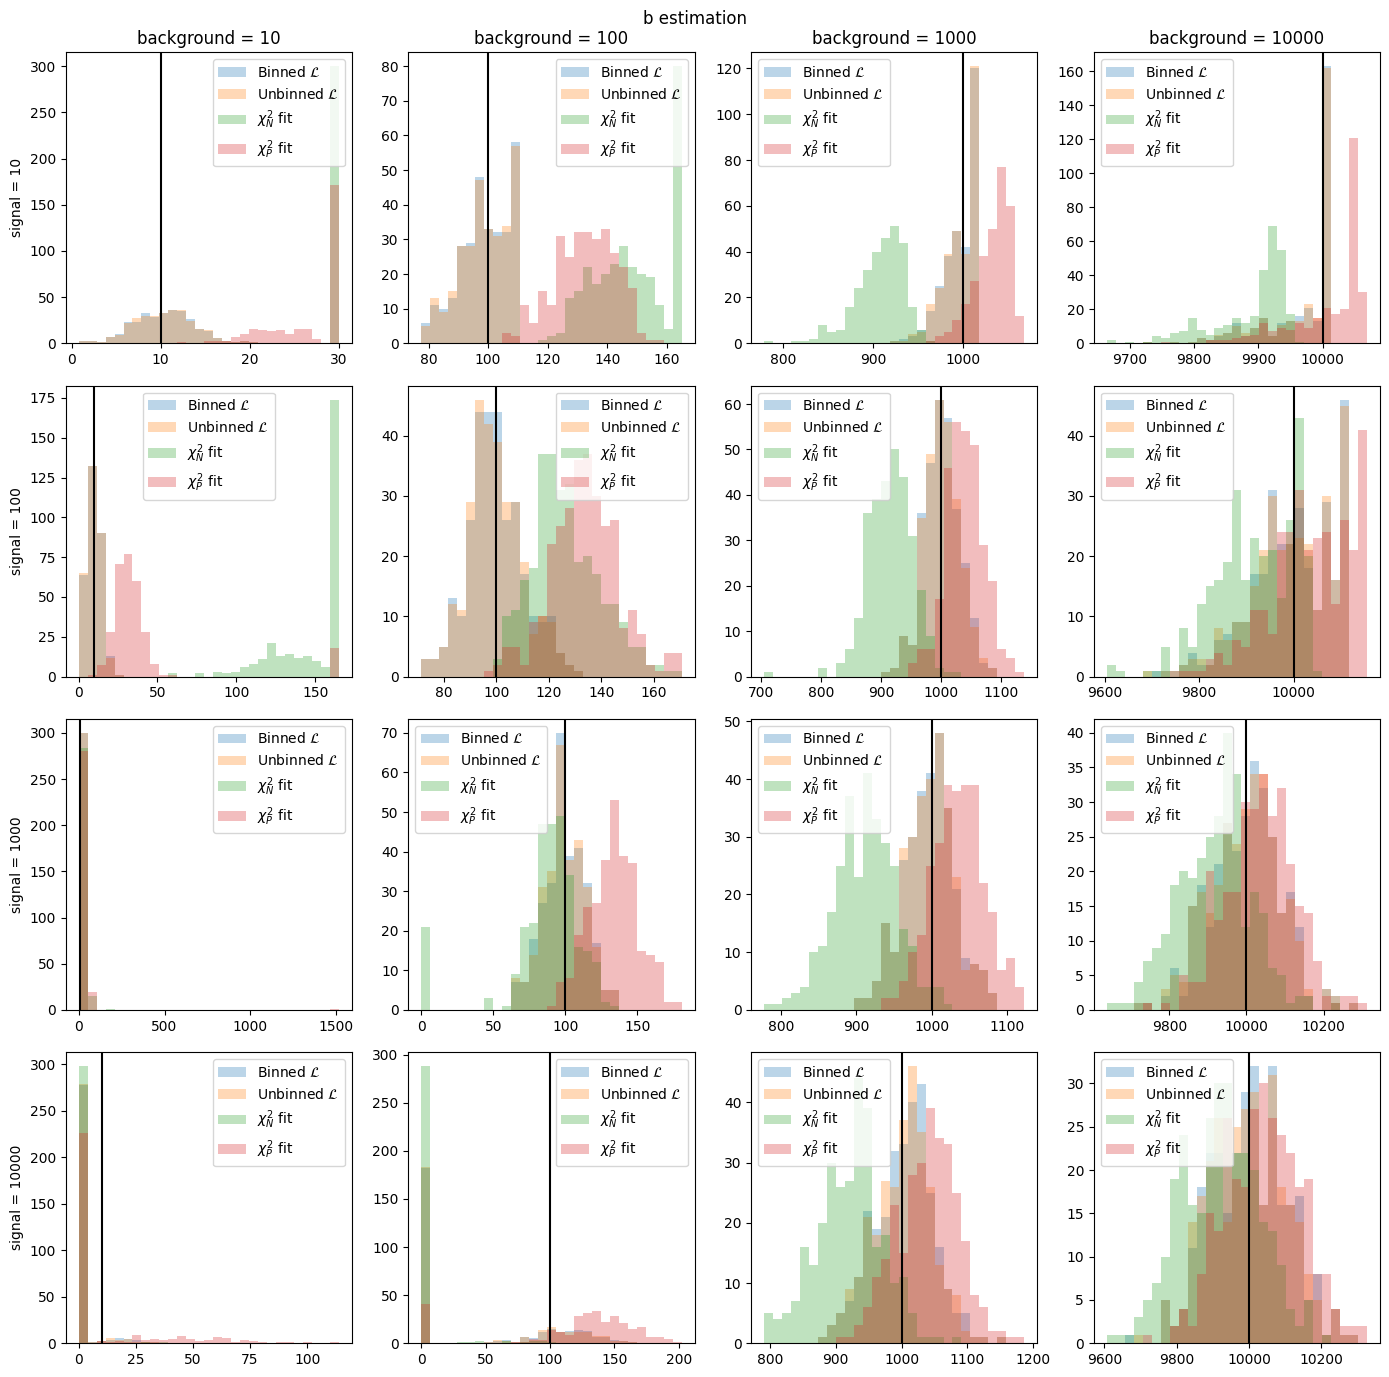

In [99]:
plot_comparison("b")

/var/folders/pt/5p7r1p1j49n8f_88l1j7jtwc0000gn/T/ipykernel_68395/4150171878.py:132: RuntimeWarning: divide by zero encountered in log
  return s + b - np.sum(np.log(s * signal_pdf_eval + b * background_pdf_eval))


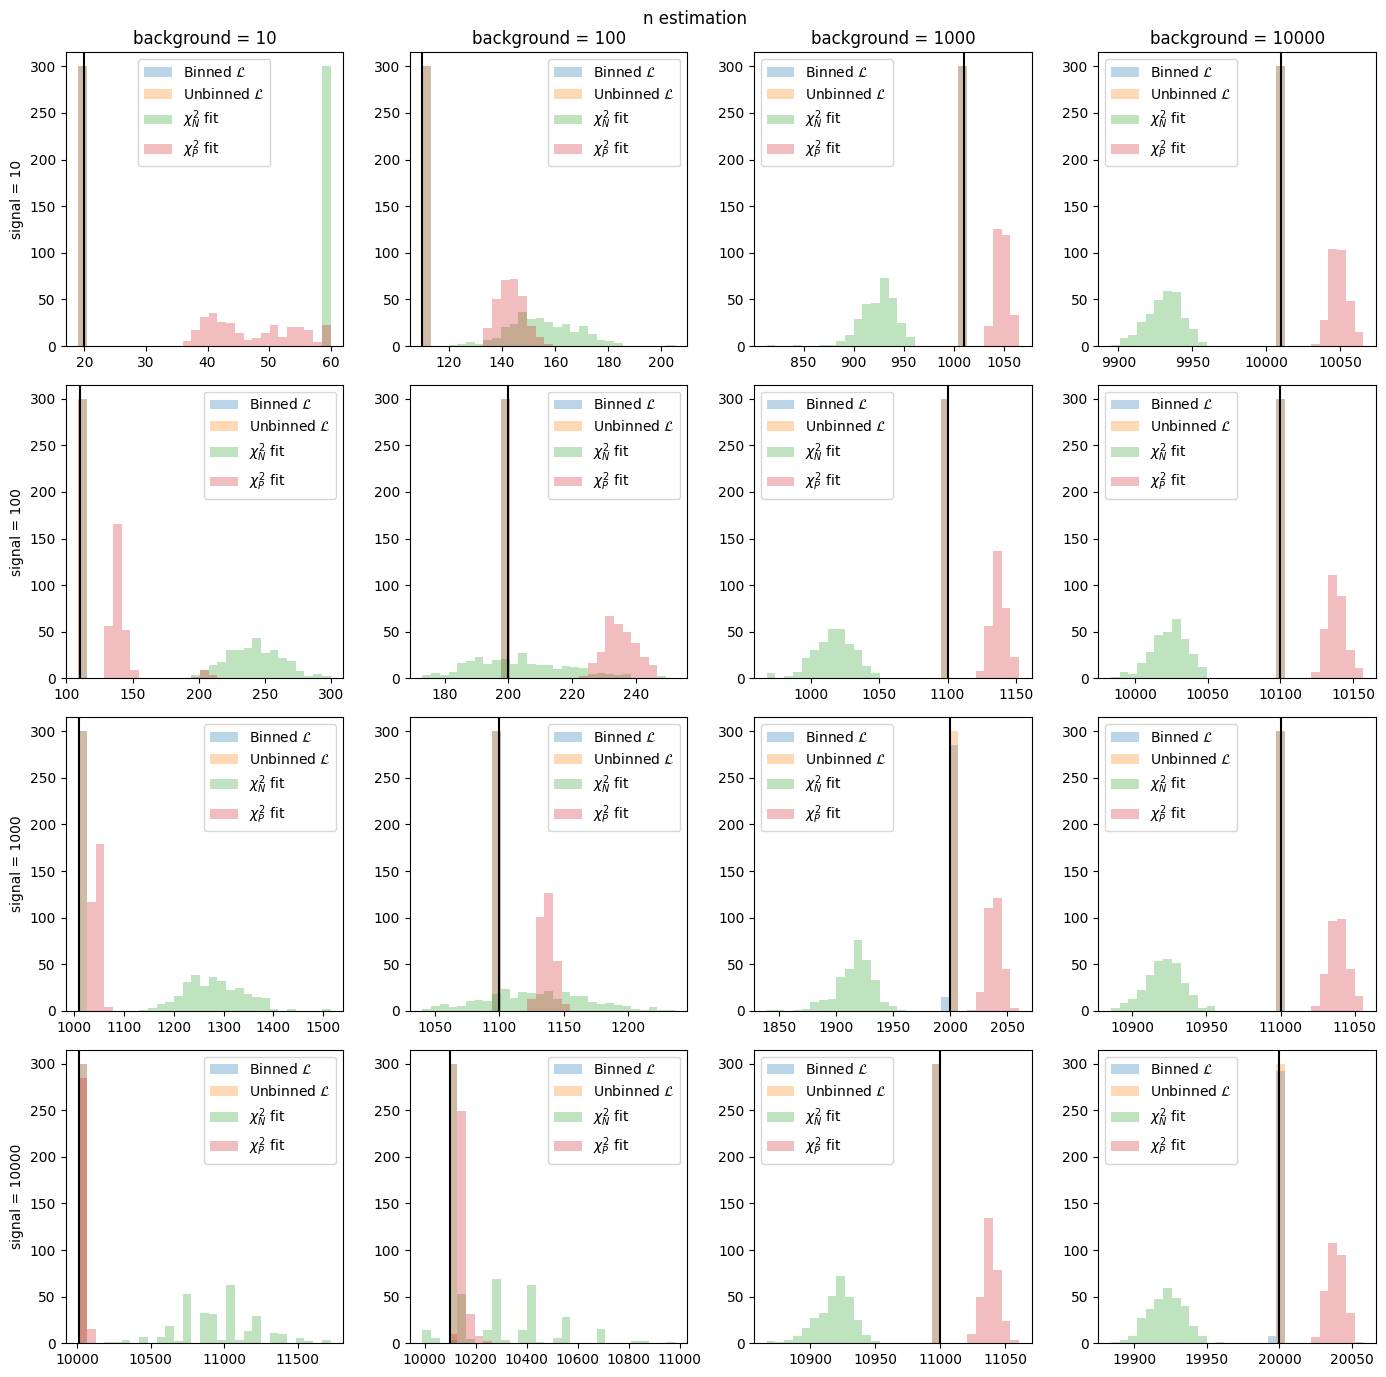

In [100]:
plot_comparison("n")